In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
import statsmodels.stats.multitest
import math

import cptac
import cptac.utils as u
import plot_utils as p
import warnings
warnings.filterwarnings('ignore')

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#cptac version
cptac.version()   

'0.8.7'

In [3]:
def create_prot_list(df):
    #Add _(number) to keep track of duplicates due to multiple isoforms 
    cols = pd.Series(df.columns[:])
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns=cols
    #get list of proteins
    prot_genes_list = df.columns.values.tolist()
    return prot_genes_list

In [4]:
#load cptac data 
brain = cptac.Gbm()
kidney = cptac.Ccrcc()
ovar = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
luad = cptac.Luad()
hnscc = cptac.Hnscc()
lscc = cptac.Lscc()
endo = cptac.Endometrial()

In [5]:
'''
Takes a cptac data object and makes a dataframe with all phospho sites. 

'''

def get_phospho_data(cancer):
    #get phosphoproteomic data 
    phospho_site = cancer.get_phosphoproteomics("tumor")
    #drop database_id and peptide 
    if (cancer != colon) & (cancer != endo):
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    if (cancer == colon): 
        phospho_site = u.reduce_multiindex(phospho_site, levels_to_drop = 2)
        phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    if cancer == endo:
         phospho_gene = u.reduce_multiindex(phospho_site, levels_to_drop = 1)
    genes = phospho_gene.columns.to_list() 
    genes = list(set(genes))#get unique list of all genes

    phospho_site.columns =phospho_site.columns.map('_'.join) #join gene and site
    phospho_site = phospho_site.loc[:,~phospho_site.T.duplicated(keep='first')] # drop columns where values are idendical
    phospho_site = phospho_site.dropna(axis=1, thresh=20) # must have atleast 20 non NA
    return phospho_site


In [6]:
gbm_phospho_df = get_phospho_data(brain)

In [11]:
gbm_phospho_egfr = gbm_phospho_df.loc[:, gbm_phospho_df.columns.str.startswith('EGFR_Y')]
gbm_phospho_egfr['mean'] = gbm_phospho_egfr.mean(axis=1)
gbm_phospho_egfr

,EGFR_Y1092,EGFR_Y1110,EGFR_Y1172,EGFR_Y1197,EGFR_Y316,EGFR_Y998,mean
Patient_ID,,,,,,,
C3L-00104,NaN,0.713628,1.977394,2.326907,-4.554552,NaN,0.115844
C3L-00365,NaN,1.900383,3.831216,4.392495,-0.689090,0.992811,2.085563
C3L-00674,0.421457,-0.851118,-0.152648,0.521459,0.000535,0.183023,0.020451
C3L-00677,-1.548885,0.399811,-1.365995,-1.272197,-0.933573,NaN,-0.944168
C3L-01040,NaN,-0.209843,-0.710159,-3.047771,-0.652991,NaN,-1.155191
...,...,...,...,...,...,...,...
C3N-03183,NaN,NaN,-0.303561,-1.838129,-0.754862,-0.623662,-0.880053
C3N-03184,0.150344,0.062236,0.221283,-0.274030,3.678630,NaN,0.767692
C3N-03186,-1.385977,-0.146275,-1.305470,-0.255198,-0.353529,-0.202275,-0.608121


In [12]:
correlations = gbm_phospho_egfr.corr(method="spearman", min_periods=20)
labels = create_prot_list(gbm_phospho_egfr)

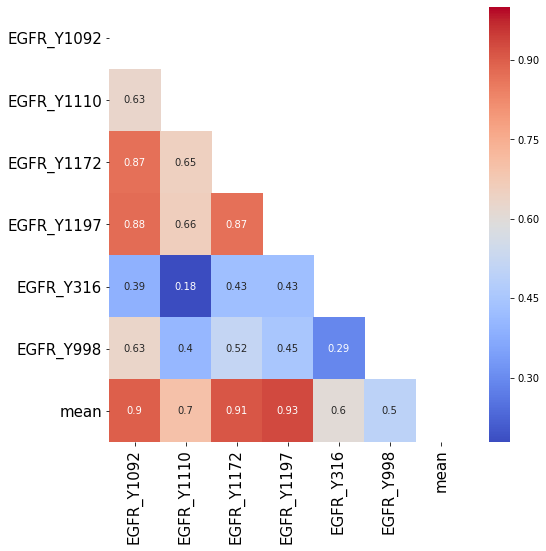

In [13]:
correlations.index=labels
correlations.columns=labels

import numpy as np
mask = np.zeros(correlations.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(8,8)) 
fig =sns.heatmap(correlations, cmap = 'coolwarm', mask = mask, annot=True)

plt.yticks(rotation=0, size=15) 
plt.xticks(rotation=90, size = 15)

plt.savefig("png_files/correlations_EGFR_Y.png", dpi=300,
            bbox_inches='tight')

In [28]:
gbm_phospho_akt = gbm_phospho_df.loc[:, gbm_phospho_df.columns.str.startswith('AKT1_S')]
gbm_phospho_akt['mean_AKT1_S'] = gbm_phospho_akt.mean(axis=1)
gbm_phospho_akt

,AKT1_S122S124S126,AKT1_S124,AKT1_S124S126,AKT1_S124S126S129,AKT1_S124S129,AKT1_S126,AKT1_S126S129,AKT1_S129,mean_AKT1_S
Patient_ID,,,,,,,,,
C3L-00104,NaN,-0.266735,NaN,-0.003699,NaN,-0.278996,-0.258196,-0.023265,-0.166178
C3L-00365,NaN,NaN,-0.126213,0.167336,NaN,-0.444445,-0.306907,0.249322,-0.092181
C3L-00674,NaN,-0.099868,0.415818,-0.025736,NaN,-0.442646,0.283930,0.080429,0.035321
C3L-00677,NaN,-0.474102,0.157080,0.081324,-0.256534,-0.261877,-0.069383,NaN,-0.137249
C3L-01040,NaN,0.213932,NaN,0.081431,NaN,-0.187680,0.093658,0.149175,0.070103
...,...,...,...,...,...,...,...,...,...
C3N-03183,0.135839,-0.048229,NaN,0.333319,NaN,NaN,0.073602,0.435285,0.185963
C3N-03184,NaN,NaN,0.029779,0.562808,0.375545,-0.122466,-0.212794,0.082460,0.119222
C3N-03186,NaN,0.190067,0.204214,-0.020094,0.208449,NaN,-0.129185,NaN,0.090690


In [40]:
correlations = gbm_phospho_akt.corr(method="spearman", min_periods=30)
labels = create_prot_list(gbm_phospho_akt)

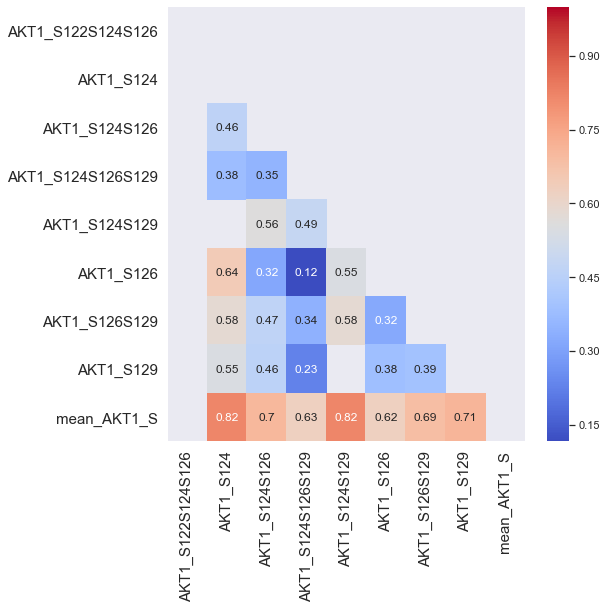

In [41]:
correlations.index=labels
correlations.columns=labels

import numpy as np
mask = np.zeros(correlations.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(8,8)) 
fig =sns.heatmap(correlations, cmap = 'coolwarm', mask = mask, annot=True)

plt.yticks(rotation=0, size=15) 
plt.xticks(rotation=90, size = 15)

plt.savefig("png_files/correlations_akt.png", dpi=300,
            bbox_inches='tight')

#Two sites because of two diff peptides 

In [43]:
gbm_phospho_stat1 = gbm_phospho_df.loc[:, gbm_phospho_df.columns.str.startswith('MAPK3')]
gbm_phospho_stat1['mean'] = gbm_phospho_stat1.mean(axis=1)
gbm_phospho_stat1

,MAPK3_T198Y204,MAPK3_T202,MAPK3_T202Y204,MAPK3_Y204,mean
Patient_ID,,,,,
C3L-00104,NaN,NaN,0.151139,-0.230992,-0.039927
C3L-00365,NaN,NaN,-0.311780,-0.036874,-0.174327
C3L-00674,NaN,NaN,0.402331,0.178739,0.290535
C3L-00677,0.900325,1.169491,NaN,0.822532,0.964116
C3L-01040,NaN,NaN,0.493165,-0.517401,-0.012118
...,...,...,...,...,...
C3N-03183,NaN,NaN,1.228165,0.251610,0.739887
C3N-03184,-1.051264,-0.419761,-0.512833,-0.507765,-0.622906
C3N-03186,NaN,NaN,-0.650900,-0.215411,-0.433155


In [44]:
correlations = gbm_phospho_stat1.corr(method="spearman", min_periods=20)
labels = create_prot_list(gbm_phospho_stat1)

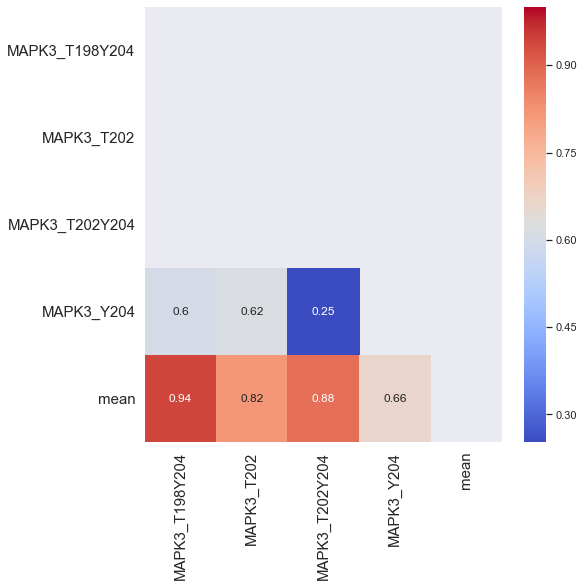

In [45]:
correlations.index=labels
correlations.columns=labels

import numpy as np
mask = np.zeros(correlations.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(8,8)) 
fig =sns.heatmap(correlations, cmap = 'coolwarm', mask = mask, annot=True)

plt.yticks(rotation=0, size=15) 
plt.xticks(rotation=90, size = 15)

plt.savefig("png_files/correlations_akt.png", dpi=300,
            bbox_inches='tight')

#Two sites because of two diff peptides 

In [35]:
def plot_pearson(df1,x_axis, y_axis, hue = "none", title = "", ra_stats = False, x_coor= 1.0 , y_coor = 1.0, show_plot = True, pval_trunc = 5 , x_label = "x_label", y_label = "y_label", save_file_name = "file_name"):
    #add option to insert own axis labels or by default 
    if x_label == "x_label":
        x_label = x_axis
    if y_label == "y_label":
        y_label = y_axis
        
    if hue != "none":   
      
        df1_subset = df1[[x_axis,y_axis,hue]]
        df1_subset = df1_subset.dropna(axis=0, how="any")
        count_row = df1_subset.shape[0]
        if count_row > 30:
            x1 = df1_subset[[x_axis]].values
            y1 = df1_subset[[y_axis]].values
            x1 = x1[:,0]
            y1 = y1[:,0]
            corr, pval = scipy.stats.pearsonr(x1,y1)

            sns.set(style="darkgrid")
            plt.rcParams["figure.figsize"] = (30,22)
            graph = sns.lmplot(x= x_axis, y= y_axis, data=df1_subset, hue= hue, fit_reg=False)
            sns.regplot(x=x1, y=y1, data=df1_subset,scatter = False)
            plt.xlabel(x_label, fontsize=20)
            plt.ylabel( y_label, fontsize=20)
            graph.set(title = title)
        else:
            return 0

    if hue == "none":
        
        df1_subset = df1[[x_axis,y_axis]]
        df1_subset = df1_subset.dropna(axis=0, how="any")
        count_row = df1_subset.shape[0]
        if count_row > 20:
            x1 = df1_subset[[x_axis]].values
            y1 = df1_subset[[y_axis]].values
            x1 = x1[:,0]
            y1 = y1[:,0]
            corr, pval = scipy.stats.pearsonr(x1,y1)

            sns.set(style="darkgrid")
            graph = sns.lmplot(x= x_axis, y= y_axis, data=df1_subset, fit_reg=False)
            sns.regplot(x=x1, y=y1, data=df1_subset,scatter = False)
            plt.title(label = title, fontsize = 15)
            plt.xlabel(x_label, fontsize=15)
            plt.ylabel( y_label, fontsize=15)
            plt.xticks(fontsize = 10)
            plt.yticks(fontsize = 10)
        else:
            return 0

    if ra_stats:
        pval = myTrunc(pval,pval_trunc)
        corr = myTrunc(corr,3)
        plt.text(x_coor,y_coor, "Correlation: %s\nPvalue: %s"%(corr,pval), fontsize = 17)
        
    if save_file_name != "file_name":
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.savefig(save_file_name+'.png', dpi = 300)
    if show_plot:
        plt.show()
        plt.clf()
        plt.close()



In [36]:
'''
@Param df1: Dataframe. Contains numeric values (such as proteomics) for pearson correlaton 
@Param x_axis: String. Used as the label for the x-axis as well as the column name for the x-axis values.
@Param y_axis:String. Used as the label for the y-axis as well as the column name for the y-axis values.
This fuction takes a dataframe with numeric values (such as proteomics) and performs a pearson correlation analysis
between two user specified columns within the dataframe. 
The function then prints the uncorrected pvalue and coorelation value.

'''
def print_stats(df1, x_axis, y_axis):
      
    df1_subset = df1[[x_axis,y_axis]]
    df1_subset = df1_subset.dropna(axis=0, how="any")
    count_row = df1_subset.shape[0]
    if count_row > 30:
        x1 = df1_subset[[x_axis]].values
        y1 = df1_subset[[y_axis]].values
        x1 = x1[:,0]
        y1 = y1[:,0]
        corr, pval = scipy.stats.pearsonr(x1,y1)
        print("Correlation: " + str(corr))
        print("P_value:" + str(pval))
        
    else: 
        return "Not Enough Data"

In [37]:
#print_stats(phospho,"AKT1_phosphoproteomics_S124","AKT1_phosphoproteomics_S126")
gbm_phospho_akt

,AKT1_S122S124S126,AKT1_S124,AKT1_S124S126,AKT1_S124S126S129,AKT1_S124S129,AKT1_S126,AKT1_S126S129,AKT1_S129,mean_AKT1_S
Patient_ID,,,,,,,,,
C3L-00104,NaN,-0.266735,NaN,-0.003699,NaN,-0.278996,-0.258196,-0.023265,-0.166178
C3L-00365,NaN,NaN,-0.126213,0.167336,NaN,-0.444445,-0.306907,0.249322,-0.092181
C3L-00674,NaN,-0.099868,0.415818,-0.025736,NaN,-0.442646,0.283930,0.080429,0.035321
C3L-00677,NaN,-0.474102,0.157080,0.081324,-0.256534,-0.261877,-0.069383,NaN,-0.137249
C3L-01040,NaN,0.213932,NaN,0.081431,NaN,-0.187680,0.093658,0.149175,0.070103
...,...,...,...,...,...,...,...,...,...
C3N-03183,0.135839,-0.048229,NaN,0.333319,NaN,NaN,0.073602,0.435285,0.185963
C3N-03184,NaN,NaN,0.029779,0.562808,0.375545,-0.122466,-0.212794,0.082460,0.119222
C3N-03186,NaN,0.190067,0.204214,-0.020094,0.208449,NaN,-0.129185,NaN,0.090690


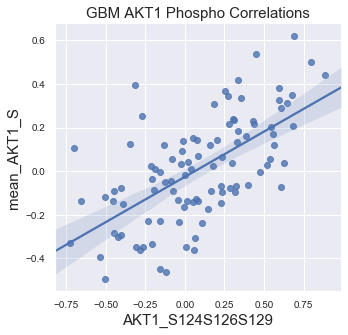

In [42]:
plot_pearson(gbm_phospho_akt,"AKT1_S124S126S129","mean_AKT1_S", hue = "none", title = "GBM AKT1 Phospho Correlations", ra_stats = False ,show_plot = True, save_file_name = "png_files/akt1_phospho")

In [38]:
plot_pearson(phospho,"AKT1_phosphoproteomics_S124","AKT1_phosphoproteomics_S126", hue = "none", title = "GBM AKT1 Phospho Correlations", ra_stats = False ,show_plot = True, save_file_name = "png_files/akt1_phospho")

NameError: name 'phospho' is not defined